In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Gaussian Mixture Models

## (1-dim) Gaussian distribution

In [2]:
# draw points from two normal distributions
values1 = np.random.normal(loc=-10, scale=10, size=10000)
values2 = np.random.normal(loc=2, scale=1, size=10000)

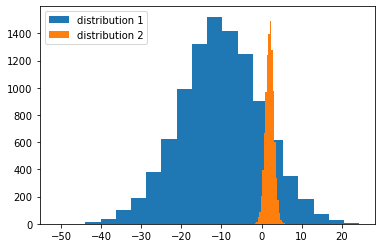

In [3]:
# plot histograms
plt.hist(values1,bins=20,label='distribution 1')
plt.hist(values2,bins=20,label='distribution 2')
plt.legend()
plt.show()

## Multivariate (2-dim) Gaussian distribution

In [9]:
def covariance_matrix(direction,evalues):
    'builds a 2x2 covariance matrix'
    
    # first vector
    q1 = np.array(direction)
    q1 = q1/np.linalg.norm(q1) # normalize
    
    # second vector (perpendicular to q1)
    q2 = np.array([-q1[1],q1[0]])
    q2 = q2/np.linalg.norm(q2) # normalize
    
    # orthogonal matrix Q
    Q = np.zeros((2,2))
    Q[:,0] = q1
    Q[:,1] = q2
    
    # diagonal matrix
    D = np.diag(evalues)
    
    return Q.dot(D.dot(Q.T))

In [5]:
cov1 = covariance_matrix(direction=[2,1],evalues=[10,1])
cov1

array([[8.2, 3.6],
       [3.6, 2.8]])

In [6]:
cov2 = covariance_matrix(direction=[1,0],evalues=[1,1])
cov2

array([[1., 0.],
       [0., 1.]])

In [7]:
mean1 = np.array([5,5])
mean2 = np.array([0,0])

In [8]:
X1 = np.random.multivariate_normal(mean = mean1, cov = cov1, size = 1000)
X2 = np.random.multivariate_normal(mean = mean2, cov = cov2, size = 1000)

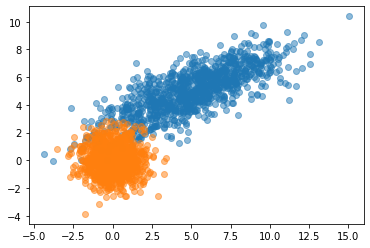

In [9]:
plt.scatter(X1[:,0],X1[:,1],label='distribution 1',alpha=0.5)
plt.scatter(X2[:,0],X2[:,1],label='distribution 2',alpha=0.5)

In [10]:
mean1,mean2

(array([5, 5]), array([0, 0]))

In [11]:
# maximum likelihood estimation
np.mean(X1,axis=0), np.mean(X2,axis=0)

(array([5.00538963, 5.00437732]), array([-0.0008462 ,  0.04643485]))

In [12]:
cov1, cov2

(array([[8.2, 3.6],
        [3.6, 2.8]]),
 array([[1., 0.],
        [0., 1.]]))

In [13]:
# maximum likelihood estimation
np.cov(X1,rowvar=False), np.cov(X2,rowvar=False)

(array([[8.48633946, 3.74541651],
        [3.74541651, 2.79785365]]),
 array([[1.00903054e+00, 4.63082138e-04],
        [4.63082138e-04, 1.05167565e+00]]))

## Gaussian mixtures

In [14]:
# Gaussian dist. probabilities
pi = [0.05,0.25,0.7]
# means
mean = [[10,5],[0,0],[-10,-10]]
#  covariance matrices
cov1 = covariance_matrix(direction=[2,1],evalues=[10,1])
cov2 = covariance_matrix(direction=[0,1],evalues=[2,2])
cov3 = covariance_matrix(direction=[1,1],evalues=[2,20])
cov = [cov1, cov2, cov3]

In [15]:
# sample m points from the Gaussian mixture (k=3)
m = 100
k = 3 
dist = np.random.choice(k,m,p=pi)
X = np.zeros((m,2))
for i in range(k):
    # number of points from dist. i
    ni = np.sum(dist==i)
    X[dist==i] = np.random.multivariate_normal(mean = mean[i], cov = cov[i], size=ni)

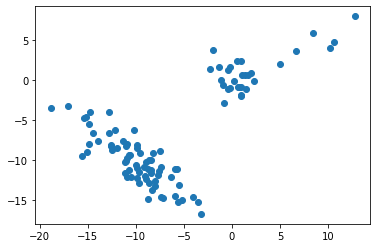

In [16]:
plt.scatter(X[:,0],X[:,1])

## Expectation-Maximization (EM) algorithm

In [10]:
def evaluate_multivariate_normal(X,mean,cov):
    m,n = X.shape
    return np.exp(-0.5*np.array([(X[i]-mean).dot((np.linalg.inv(cov)).dot(X[i]-mean))
                        for i in range(m)])) /  np.sqrt(np.linalg.det(cov)*(2*np.pi)**n)

In [14]:
def sample_gaussian_mixture(m,cov,mean,pi):
    k = len(mean) # number of gaussian distributions
    dist = np.random.choice(k,m,p=pi) # distributions
    X = np.zeros((m,2))
    for i in range(k):
        ni = np.sum(dist==i) # number of points from dist. i
        X[dist==i] = np.random.multivariate_normal(mean = mean[i], cov = cov[i], size=ni)
    return X

In [15]:
# toy example:

#  dist. probabilities
pi = [0.6,0.2,0.2]
# means
mean1 = np.array([2,2])
mean2 = np.array([-2,-2])
mean3 = np.array([2,-2])
mean = [mean1,mean2,mean3]
# covariance matrices
cov1 = covariance_matrix(direction=[2,1],evalues=[1,.2])
cov2 = covariance_matrix(direction=[0,1],evalues=[0.1,0.1])
cov3 = covariance_matrix(direction=[1,0],evalues=[2,0.2])
cov = [cov1,cov2,cov3]

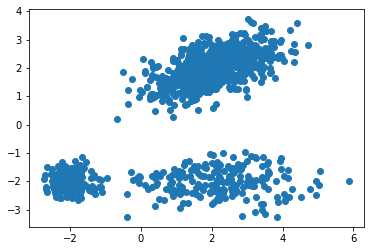

In [16]:
# sample m points from the Gaussian mixture
m = 1000
X = sample_gaussian_mixture(m,cov,mean,pi)
plt.scatter(X[:,0],X[:,1])

In [17]:
def em(X,k,max_iter=100):
    'expectation-maximization algorithm'
    
    # size of X
    m,n = X.shape
    
    # initializations
    cov = [np.eye(n) for i in range(k)] # identity matrices
    mean = X[np.random.choice(m,k,replace=False)] 
    pi = [1/k for i in range(k)]
    
    # initialize responsibility matrix
    R = np.zeros((m,k))
    
    # EM iterations
    for i in range(max_iter):
        # EXPECTATION STEP
        for i in range(k):
            R[:,i] = evaluate_multivariate_normal(X,mean[i],cov[i])
        # multiply by cluster probabilities pi
        R = R*pi
        # normalize rows
        R = R/np.sum(R,axis=1,keepdims=True)
        
        # MAXIMIZATION STEP
        mc = np.sum(R,axis=0)
        pi = mc/m
        for i in range(k):
            # weighted mean
            mean[i] = np.average(X,axis=0,weights=R[:,i])
            # weighted covariance matrix
            cov[i] = np.cov(X,rowvar=False,aweights=R[:,i])
    return cov,mean

In [18]:
k = 3
max_iter = 100
cov,mean=em(X,k,max_iter)

In [19]:
mean

array([[-2.00391411, -1.99826956],
       [ 2.03412277,  2.00311453],
       [ 2.18803272, -2.0234306 ]])

In [20]:
cov

[array([[ 0.11406748, -0.00513017],
        [-0.00513017,  0.08831788]]),
 array([[0.87214045, 0.3189564 ],
        [0.3189564 , 0.35749893]]),
 array([[1.59739065, 0.01129257],
        [0.01129257, 0.23227526]])]

In [23]:
def plot_log_probability_distribution(X,cov,mean,pi):
    """
    this function plots:
        - level curves of the proba. distribution (negative logarithm)
        - cluster means
        - cluster boundaries
    
    """
    from matplotlib.colors import LogNorm  
    resolution = 500
    
    # number of clusters
    k = len(pi)
    
    # create a mesh grid
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    points = np.c_[xx.ravel(), yy.ravel()]
    Rpoints = np.zeros((resolution**2,k))
    for i in range(k):
        Rpoints[:,i] = evaluate_multivariate_normal(points,mean[i],cov[i])
    # multiply by cluster probabilities pi
    Rpoints = Rpoints*pi
    # sum along columns
    prob = -np.log(np.sum(Rpoints,axis=1).reshape(xx.shape))
    # cluster prediction
    pred = np.argmax(Rpoints,axis=1).reshape(xx.shape)

    plt.contourf(xx, yy, prob,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                     levels=np.logspace(0, 2, 12))

    plt.contour(xx, yy, prob,linewidths=1,colors='black',
               norm=LogNorm(vmin=1.0, vmax=30.0),
                     levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, pred,
                    linewidths=2, colors='r', linestyles='dashed')
    # plot means
    for i in range(k):
        plt.scatter(mean[i][0],mean[i][1],
                    marker='o', s=20, linewidths=8,
                    color='w', zorder=10, alpha=0.9)
        plt.scatter(mean[i][0],mean[i][1],
                    marker='x', s=50, linewidths=2,
                    color='r', zorder=11, alpha=1)

    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plt.colorbar()
    plt.title('log probability distribution')

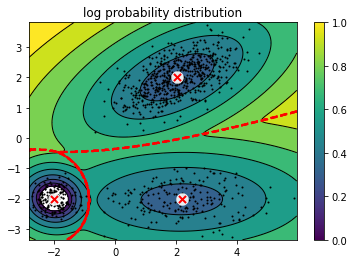

In [24]:
plot_log_probability_distribution(X,cov,mean,pi)

In [33]:
def cluster_probabilities(X,cov,mean,pi):
    m,n = X.shape
    k = len(pi)
    
    # responsibility matrix
    R = np.zeros((m,k))
    for i in range(k):
        R[:,i] = evaluate_multivariate_normal(X,mean[i],cov[i])
    # multiply by cluster probabilities pi
    R = R*pi
    # normalize rows
    R = R/np.sum(R,axis=1,keepdims=True)
    return R

In [42]:
newX = np.array([[1,-2],[2,0],[-2,-3]])
newX

array([[ 1, -2],
       [ 2,  0],
       [-2, -3]])

In [43]:
cluster_probabilities(newX,cov,mean,pi).round(2)

array([[0.  , 0.  , 1.  ],
       [0.  , 0.71, 0.29],
       [0.99, 0.  , 0.01]])

In [44]:
def predict_cluster(X,cov,mean,pi):
    R = cluster_probabilities(X,cov,mean,pi)
    return np.argmax(R,axis=1)

In [49]:
predict_cluster(newX,cov,mean,pi)

array([2, 1, 0], dtype=int64)

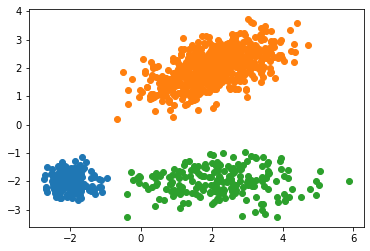

In [50]:
clusters = predict_cluster(X,cov,mean,pi)
for i in range(k):
    plt.scatter(X[clusters==i,0],X[clusters==i,1])